## Set up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_venn import venn2

# check the current working directory
current_working_directory = Path.cwd()
print(current_working_directory)

/Users/elaine/Documents/MRes Project 2/Final deliverables/retrieval_vs_freezing/RNAscope_analysis/TRAP(retrieval)-specific code


In [8]:
brain_id = 'JKAY11.1g'
global_indices = None

In [9]:
cell_type_directories = ['Vgat_alsoTRAPed', 'Vglut_alsoTRAPed', 'TRAPed_alsoVgat', 'TRAPed_alsoVglut']
column_colors = ['royalblue', 'gold', 'darkcyan', 'darkgoldenrod']

# get name of all images/slices
# just first slice
# slice_names = [[f.stem for f in Path().glob('annotation_results/DAPIcells_alsoTRAPed/*.ome.tif.csv')][0]]
# # all slices
slice_names = [f.stem for f in Path().glob(f'registered/{brain_id}/Vgat_alsoTRAPed/*.ome.tif.csv')]
if brain_id in ['JKAY4.2b', 'JKAY11.1g']:
    slice_names.sort(key=lambda x: int(x.split('.')[0]))
else:
    slice_names.sort()
print('Alphabetically sorted: ')
print('\n'.join(slice_names))
# reorder slices to be anterior-to-posterior --> for TRAP_retrieval data, already in order
if brain_id == 'JKAY4.2b':
    global_indices = [3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8]
elif brain_id == 'JKAY11.1g':
    global_indices = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 6, 6, 7, 7, 8]
elif brain_id == 'JKAY11.2g':
    slice_names = slice_names[:-1] # for 11.2g only
    global_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
elif brain_id == 'JKAY11.6c':
    global_indices = [0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 8]
print('Anatomically sorted: ')
print('\n'.join(slice_names))

Alphabetically sorted: 
1. JKBY11.1d_A1_Scan2.qptiff - resolution #1_Region 6.ome.tif
2. JKBY11.1d_A2_Scan2.qptiff - resolution #1_Region 1.ome.tif
3. JKBY11.1d_A2_Scan2.qptiff - resolution #1_Region 2.ome.tif
4. JKBY11.1d_A2_Scan2.qptiff - resolution #1_Region 4.ome.tif
5. JKBY11.1d_A2_Scan2.qptiff - resolution #1_Region 5.ome.tif
6. JKBY11.1d_A2_Scan2.qptiff - resolution #1_Region 6.ome.tif
7. JKBY11.1b_A3_Scan1.qptiff - resolution #1_Region 1.ome.tif
8. JKBY11.1b_A3_Scan1.qptiff - resolution #1_Region 2.ome.tif
9. JKBY11.1b_A3_Scan1.qptiff - resolution #1_Region 3.ome.tif
10. JKBY11.1b_A3_Scan1.qptiff - resolution #1_Region 4.ome.tif
11. JKBY11.1b_A3_Scan1.qptiff - resolution #1_Region 5.ome.tif
12. JKBY11.1b_A3_Scan1.qptiff - resolution #1_Region 6.ome.tif
13. JKBY11.1b_A4_Scan1.qptiff - resolution #1_Region 1.ome.tif
14. JKBY11.1b_A4_Scan1.qptiff - resolution #1_Region 2.ome.tif
15. JKBY11.1b_A4_Scan1.qptiff - resolution #1_Region 3.ome.tif
16. JKBY11.1b_A4_Scan1.qptiff - resoluti

## Analysis

In [10]:
annotation_dir = f"registered/{brain_id}"
output_dir = f"registered/{brain_id}/calculated_outputs"

# initialize dictionary
num_positive = {
    'Region': ['dmPAG', 'dlPAG', 'lPAG', 'vlPAG']
}
results_per_slice = {
    'Slice index': [],
    'Region': []
}
results_per_slice_revised = {
    'Slice index': [],
    'Region': []
}
vgat_vglut_per_slice = {
    'Slice index': [],
    'Region': [],
    '# Vgat': [],
    '# Vglut': [],
#     '# Vgat+Vglut': []
}

if brain_id == 'JKAY4.2b':
    for cell_type_idx, cell_type_dir in enumerate(cell_type_directories):
        dmPAG_pos_all = []
        dlPAG_pos_all = []
        lPAG_pos_all = []
        vlPAG_pos_all = []

        ## TO KEEP TRACK OF DATA PER SLICE INDIVIDUALLY
        results_per_slice[f'{cell_type_dir}_numerator'] = []
        results_per_slice[f'{cell_type_dir}_denominator'] = []
        results_per_slice[f'{cell_type_dir}_percent'] = []
        results_per_slice_revised[f'{cell_type_dir}'] = []

        for slice_idx, slice_name in enumerate(slice_names):
#             print(cell_type_dir + ' ' + slice_name)
            slice_idx_string = f'Slice {slice_idx}'
            annotations_filename = f"{annotation_dir}/{cell_type_dir}/{slice_name}.csv"

            annotations_df = pd.read_csv(annotations_filename, delimiter = '\t')

            if 'dmPAG' not in annotations_df['Name'].values:
    #             print('NOT IN' + slice_name)
                continue

            if 'Num Detections' not in annotations_df.columns:
                print("Slice without 'Num Detections' column detected: " + slice_name + '; ' + cell_type_dir)
                annotations_df['Num Detections'] = 0 
                annotations_df['Num Positive'] = 0
                annotations_df['Num Negative'] = 0 

            # check for divide by 0 = Nan
            annotations_df.loc[annotations_df['Num Detections'] == 0, 'Positive %'] = 0.0

            if 'Num Positive' not in annotations_df.columns:
                print("Slice without 'Num Positive' column detected: " + slice_name + '; ' + cell_type_dir)
                # check that there were 0 positive cell detections
                if (annotations_df[annotations_df['Num Detections'] != 0]['Num Negative'] != annotations_df[annotations_df['Num Detections'] != 0]['Num Detections']).all():
                    print("ERROR -- check Num Detections, Num Negative, Num Positive")
                    display(annotations_df[annotations_df['Num Detections'] != 0])
                    break
                annotations_df['Num Positive'] = 0 
            if 'Num Negative' not in annotations_df.columns:
                print("Slice without 'Num Negative' column detected: " + slice_name + '; ' + cell_type_dir)
                # check that there were 0 positive cell detections
                if (annotations_df[annotations_df['Num Detections'] != 0]['Num Positive'] != annotations_df[annotations_df['Num Detections'] != 0]['Num Detections']).all():
                    print("ERROR -- check Num Detections, Num Negative, Num Positive")
                    display(annotations_df[annotations_df['Num Detections'] != 0])
                    break
                annotations_df['Num Negative'] = 0 

            columns_of_interest = ['Name', 'Parent', 'Num Detections', 'Num Negative', 'Num Positive', 'Positive %']
            dmPAG_row = annotations_df[annotations_df['Name'] == 'dmPAG'][columns_of_interest]
            dlPAG_row = annotations_df[annotations_df['Name'] == 'dlPAG'][columns_of_interest]
            lPAG_row = annotations_df[annotations_df['Name'] == 'lPAG'][columns_of_interest]
            if slice_name == '4. JKBY4.2b_A3_Scan1.qptiff - resolution #1_Region 4.ome.tif':
                vlPAG_row = annotations_df[annotations_df['Name'] == 'vPAG'][columns_of_interest]
            else:
                vlPAG_row = annotations_df[annotations_df['Name'] == 'vlPAG'][columns_of_interest]

            # record number of Vgat cells/number of Vglut + Vgat cells and Vglut cells/number of Vglut + Vgat cells 
            if cell_type_dir == 'Vgat_alsoTRAPed': 
                vgat_vglut_per_slice['Slice index'].extend([slice_idx_string for _ in range(4)])
                vgat_vglut_per_slice['Region'].extend(['dmPAG', 'dlPAG', 'lPAG', 'vlPAG'])
                vgat_vglut_per_slice['# Vgat'].extend([dmPAG_row['Num Detections'].item(), dlPAG_row['Num Detections'].item(), lPAG_row['Num Detections'].item(), vlPAG_row['Num Detections'].item()])
            if cell_type_dir == 'Vglut_alsoTRAPed': 
                vgat_vglut_per_slice['# Vglut'].extend([dmPAG_row['Num Detections'].item(), dlPAG_row['Num Detections'].item(), lPAG_row['Num Detections'].item(), vlPAG_row['Num Detections'].item()])
                if slice_idx + 1 == len(slice_names):
                    display([len(val) for val in vgat_vglut_per_slice.values()])
                    vgat_vglut_per_slice = pd.DataFrame.from_dict(vgat_vglut_per_slice)
                    vgat_vglut_per_slice['# Vgat+Vglut'] = vgat_vglut_per_slice['# Vgat'].add(vgat_vglut_per_slice['# Vglut'], axis=0)
                    vgat_vglut_per_slice['Vgat/(Vgat+Vglut)'] = vgat_vglut_per_slice['# Vgat'].div(vgat_vglut_per_slice['# Vgat+Vglut'], axis=0)
                    vgat_vglut_per_slice['Vglut/(Vgat+Vglut)'] = vgat_vglut_per_slice['# Vglut'].div(vgat_vglut_per_slice['# Vgat+Vglut'], axis=0)

            dmPAG_revised = round(dmPAG_row['Positive %'].item(), 2)
            dlPAG_revised = round(dlPAG_row['Positive %'].item(), 2)
            lPAG_revised = round(lPAG_row['Positive %'].item(), 2)
            vlPAG_revised = round(vlPAG_row['Positive %'].item(), 2)
            
            dmPAG_pos = dmPAG_row['Num Positive'].item()
            dlPAG_pos = dlPAG_row['Num Positive'].item()
            lPAG_pos = lPAG_row['Num Positive'].item()
            vlPAG_pos = vlPAG_row['Num Positive'].item()
            dmPAG_denom = dmPAG_row['Num Detections'].item()
            dlPAG_denom = dlPAG_row['Num Detections'].item()
            lPAG_denom = lPAG_row['Num Detections'].item()
            vlPAG_denom = vlPAG_row['Num Detections'].item()
            dmPAG_percent = dmPAG_row['Positive %'].item()
            dlPAG_percent = dlPAG_row['Positive %'].item()
            lPAG_percent = lPAG_row['Positive %'].item()
            vlPAG_percent = vlPAG_row['Positive %'].item()

            # record data per slice individually
            if cell_type_idx == 0:
                results_per_slice['Slice index'].extend([slice_idx_string for _ in range(4)])
                results_per_slice['Region'].extend(['dmPAG', 'dlPAG', 'lPAG', 'vlPAG'])
                results_per_slice_revised['Slice index'].extend([slice_idx_string for _ in range(4)])
                results_per_slice_revised['Region'].extend(['dmPAG', 'dlPAG', 'lPAG', 'vlPAG'])        
            results_per_slice[f'{cell_type_dir}_numerator'].extend([dmPAG_pos, dlPAG_pos, lPAG_pos, vlPAG_pos])
            results_per_slice[f'{cell_type_dir}_denominator'].extend([dmPAG_denom, dlPAG_denom, lPAG_denom, vlPAG_denom])
            results_per_slice[f'{cell_type_dir}_percent'].extend([dmPAG_percent, dlPAG_percent, lPAG_percent, vlPAG_percent])
            results_per_slice_revised[f'{cell_type_dir}'].extend([dmPAG_revised, dlPAG_revised, lPAG_revised, vlPAG_revised])

    results_per_slice_df = pd.DataFrame.from_dict(results_per_slice)
    print(results_per_slice_df.shape)
    display(results_per_slice_df)

    results_per_slice_df_revised = pd.DataFrame.from_dict(results_per_slice_revised)
    print(results_per_slice_df_revised.shape)
    display(results_per_slice_df_revised)

    # fix vgat/vglut datatable 
    display(vgat_vglut_per_slice)
    vgat_vglut_per_slice_revised = {
        'Slice index': [],
        'Region': [],
        'Vgat/(Vgat+Vglut)': [],
        'Vglut/(Vgat+Vglut)': []
    }
    for slice_idx, slice_name in enumerate(slice_names):
        slice_idx_string = f'Slice {slice_idx}'
        display(vgat_vglut_per_slice)
        curr_slice = vgat_vglut_per_slice[vgat_vglut_per_slice['Slice index'] == slice_idx_string]

        dmPAG_rows = curr_slice[curr_slice['Region'].isin(['dmPAG'])]
        dlPAG_rows = curr_slice[curr_slice['Region'].isin(['dlPAG'])]
        lPAG_rows = curr_slice[curr_slice['Region'].isin(['lPAG'])]
        vlPAG_rows = curr_slice[curr_slice['Region'].isin(['vlPAG'])]

        vgat_vglut_per_slice_revised['Slice index'].extend([slice_idx_string for _ in range(4)])
        vgat_vglut_per_slice_revised['Region'].extend(['dmPAG', 'dlPAG', 'lPAG', 'vlPAG'])
        vgat_vglut_per_slice_revised['Vgat/(Vgat+Vglut)'].extend([
            dmPAG_rows['Vgat/(Vgat+Vglut)'].mean(), 
            dlPAG_rows['Vgat/(Vgat+Vglut)'].mean(), 
            lPAG_rows['Vgat/(Vgat+Vglut)'].mean(), 
            vlPAG_rows['Vgat/(Vgat+Vglut)'].mean()])
        vgat_vglut_per_slice_revised['Vglut/(Vgat+Vglut)'].extend([
            dmPAG_rows['Vglut/(Vgat+Vglut)'].mean(), 
            dlPAG_rows['Vglut/(Vgat+Vglut)'].mean(), 
            lPAG_rows['Vglut/(Vgat+Vglut)'].mean(), 
            vlPAG_rows['Vglut/(Vgat+Vglut)'].mean()])
    vgat_vglut_per_slice_revised = pd.DataFrame.from_dict(vgat_vglut_per_slice_revised)
    vgat_vglut_per_slice_revised['Vgat/(Vgat+Vglut)'] = vgat_vglut_per_slice_revised['Vgat/(Vgat+Vglut)'] * 100
    vgat_vglut_per_slice_revised['Vglut/(Vgat+Vglut)'] = vgat_vglut_per_slice_revised['Vglut/(Vgat+Vglut)'] * 100
    vgat_vglut_per_slice['Vgat/(Vgat+Vglut)'] = vgat_vglut_per_slice['Vgat/(Vgat+Vglut)'] * 100
    vgat_vglut_per_slice['Vglut/(Vgat+Vglut)'] = vgat_vglut_per_slice['Vglut/(Vgat+Vglut)'] * 100
    display(vgat_vglut_per_slice_revised)
else: 

    for cell_type_idx, cell_type_dir in enumerate(cell_type_directories):
        dmPAG_pos_all = []
        dlPAG_pos_all = []
        lPAG_pos_all = []
        vlPAG_pos_all = []

        ## TO KEEP TRACK OF DATA PER SLICE INDIVIDUALLY
        results_per_slice[f'{cell_type_dir}_numerator'] = []
        results_per_slice[f'{cell_type_dir}_denominator'] = []
        results_per_slice[f'{cell_type_dir}_percent'] = []
        results_per_slice_revised[f'{cell_type_dir}'] = []

        for slice_idx, slice_name in enumerate(slice_names):
#             print(cell_type_dir + ' ' + slice_name)
            slice_idx_string = f'Slice {slice_idx}'
            annotations_filename = f"{annotation_dir}/{cell_type_dir}/{slice_name}.csv"

            annotations_df = pd.read_csv(annotations_filename, delimiter = '\t')

            if 'dmPAG' not in annotations_df['Name'].values:
    #             print('NOT IN' + slice_name)
                continue

            if 'Num Detections' not in annotations_df.columns:
                print("Slice without 'Num Detections' column detected: " + slice_name + '; ' + cell_type_dir)
                annotations_df['Num Detections'] = 0 
                annotations_df['Num Positive'] = 0
                annotations_df['Num Negative'] = 0 

            # check for divide by 0 = Nan
            annotations_df.loc[annotations_df['Num Detections'] == 0, 'Positive %'] = 0.0

            if 'Num Positive' not in annotations_df.columns:
                print("Slice without 'Num Positive' column detected: " + slice_name + '; ' + cell_type_dir)
                # check that there were 0 positive cell detections
                if (annotations_df[annotations_df['Num Detections'] != 0]['Num Negative'] != annotations_df[annotations_df['Num Detections'] != 0]['Num Detections']).all():
                    print("ERROR -- check Num Detections, Num Negative, Num Positive")
                    display(annotations_df[annotations_df['Num Detections'] != 0])
                    break
                annotations_df['Num Positive'] = 0 
            if 'Num Negative' not in annotations_df.columns:
                print("Slice without 'Num Negative' column detected: " + slice_name + '; ' + cell_type_dir)
                # check that there were 0 positive cell detections
                if (annotations_df[annotations_df['Num Detections'] != 0]['Num Positive'] != annotations_df[annotations_df['Num Detections'] != 0]['Num Detections']).all():
                    print("ERROR -- check Num Detections, Num Negative, Num Positive")
                    display(annotations_df[annotations_df['Num Detections'] != 0])
                    break
                annotations_df['Num Negative'] = 0 

            columns_of_interest = ['Name', 'Class', 'Parent', 'Num Detections', 'Num Negative', 'Num Positive', 'Positive %']
            dmPAG_row = annotations_df[annotations_df['Name'] == 'dmPAG'][columns_of_interest]
            if brain_id == 'JKAY11.6c':
                dlPAG_l_row = annotations_df[annotations_df['Name'] == 'dlPAG-left'][columns_of_interest]
                dlPAG_r_row = annotations_df[annotations_df['Name'] == 'dlPAG-right'][columns_of_interest]
                lPAG_l_row = annotations_df[annotations_df['Name'] == 'lPAG-left'][columns_of_interest]
                lPAG_r_row = annotations_df[annotations_df['Name'] == 'lPAG-right'][columns_of_interest]
                vlPAG_l_row = annotations_df[annotations_df['Name'] == 'vlPAG-left'][columns_of_interest]
                vlPAG_r_row = annotations_df[annotations_df['Name'] == 'vlPAG-right'][columns_of_interest]
            else:
                dlPAG_l_row = annotations_df[annotations_df['Name'] == 'dlPAG-l'][columns_of_interest]
                dlPAG_r_row = annotations_df[annotations_df['Name'] == 'dlPAG-r'][columns_of_interest]
                lPAG_l_row = annotations_df[annotations_df['Name'] == 'lPAG-l'][columns_of_interest]
                lPAG_r_row = annotations_df[annotations_df['Name'] == 'lPAG-r'][columns_of_interest]
                vlPAG_l_row = annotations_df[annotations_df['Name'] == 'vlPAG-l'][columns_of_interest]
                vlPAG_r_row = annotations_df[annotations_df['Name'] == 'vlPAG-r'][columns_of_interest]

            # record number of Vgat cells/number of Vglut + Vgat cells and Vglut cells/number of Vglut + Vgat cells 
            if cell_type_dir == 'Vgat_alsoTRAPed':
                vgat_vglut_per_slice['Slice index'].extend([slice_idx_string for _ in range(7)])
                vgat_vglut_per_slice['Region'].extend(['dmPAG', 'dlPAG_l', 'dlPAG_r', 'lPAG_l', 'lPAG_r', 'vlPAG_l', 'vlPAG_r'])
                vgat_vglut_per_slice['# Vgat'].extend([dmPAG_row['Num Detections'].item(), dlPAG_l_row['Num Detections'].item(), dlPAG_r_row['Num Detections'].item(), lPAG_l_row['Num Detections'].item(), lPAG_r_row['Num Detections'].item(), vlPAG_l_row['Num Detections'].item(), vlPAG_r_row['Num Detections'].item()])
            if cell_type_dir == 'Vglut_alsoTRAPed': 
                vgat_vglut_per_slice['# Vglut'].extend([dmPAG_row['Num Detections'].item(), dlPAG_l_row['Num Detections'].item(), dlPAG_r_row['Num Detections'].item(), lPAG_l_row['Num Detections'].item(), lPAG_r_row['Num Detections'].item(), vlPAG_l_row['Num Detections'].item(), vlPAG_r_row['Num Detections'].item()])
                if slice_idx + 1 == len(slice_names):
                    vgat_vglut_per_slice = pd.DataFrame.from_dict(vgat_vglut_per_slice)
                    vgat_vglut_per_slice['# Vgat+Vglut'] = vgat_vglut_per_slice['# Vgat'].add(vgat_vglut_per_slice['# Vglut'], axis=0)
                    vgat_vglut_per_slice['Vgat/(Vgat+Vglut)'] = vgat_vglut_per_slice['# Vgat'].div(vgat_vglut_per_slice['# Vgat+Vglut'], axis=0)
                    vgat_vglut_per_slice['Vglut/(Vgat+Vglut)'] = vgat_vglut_per_slice['# Vglut'].div(vgat_vglut_per_slice['# Vgat+Vglut'], axis=0)

            dmPAG_revised = round(dmPAG_row['Positive %'].item(), 2)
            dlPAG_revised = round((dlPAG_l_row['Positive %'].item() + dlPAG_r_row['Positive %'].item()) / 2, 2)
            lPAG_revised = round((lPAG_l_row['Positive %'].item() + lPAG_r_row['Positive %'].item()) / 2, 2)
            vlPAG_revised = round((vlPAG_l_row['Positive %'].item() + vlPAG_r_row['Positive %'].item()) / 2, 2)
            dmPAG_pos = dmPAG_row['Num Positive'].item()
            dlPAG_l_pos = dlPAG_l_row['Num Positive'].item()
            dlPAG_r_pos = dlPAG_r_row['Num Positive'].item()
            lPAG_l_pos = lPAG_l_row['Num Positive'].item()
            lPAG_r_pos = lPAG_r_row['Num Positive'].item()
            vlPAG_l_pos = vlPAG_l_row['Num Positive'].item()
            vlPAG_r_pos = vlPAG_r_row['Num Positive'].item()
            dmPAG_denom = dmPAG_row['Num Detections'].item()
            dlPAG_l_denom = dlPAG_l_row['Num Detections'].item()
            dlPAG_r_denom = dlPAG_r_row['Num Detections'].item()
            lPAG_l_denom = lPAG_l_row['Num Detections'].item()
            lPAG_r_denom = lPAG_r_row['Num Detections'].item()
            vlPAG_l_denom = vlPAG_l_row['Num Detections'].item()
            vlPAG_r_denom = vlPAG_r_row['Num Detections'].item()
            dmPAG_percent = dmPAG_row['Positive %'].item()
            dlPAG_l_percent = dlPAG_l_row['Positive %'].item()
            dlPAG_r_percent = dlPAG_r_row['Positive %'].item()
            lPAG_l_percent = lPAG_l_row['Positive %'].item()
            lPAG_r_percent = lPAG_r_row['Positive %'].item()
            vlPAG_l_percent = vlPAG_l_row['Positive %'].item()
            vlPAG_r_percent = vlPAG_r_row['Positive %'].item()

            # record data per slice individually
            if cell_type_idx == 0:
                results_per_slice['Slice index'].extend([slice_idx_string for _ in range(7)])
                results_per_slice['Region'].extend(['dmPAG', 'dlPAG_l', 'dlPAG_r', 'lPAG_l', 'lPAG_r', 'vlPAG_l', 'vlPAG_r'])
                results_per_slice_revised['Slice index'].extend([slice_idx_string for _ in range(4)])
                results_per_slice_revised['Region'].extend(['dmPAG', 'dlPAG', 'lPAG', 'vlPAG'])        
            results_per_slice[f'{cell_type_dir}_numerator'].extend([dmPAG_pos, dlPAG_l_pos, dlPAG_r_pos, lPAG_l_pos, lPAG_r_pos, vlPAG_l_pos, vlPAG_r_pos])
            results_per_slice[f'{cell_type_dir}_denominator'].extend([dmPAG_denom, dlPAG_l_denom, dlPAG_r_denom, lPAG_l_denom, lPAG_r_denom, vlPAG_l_denom, vlPAG_r_denom])
            results_per_slice[f'{cell_type_dir}_percent'].extend([dmPAG_percent, dlPAG_l_percent, dlPAG_r_percent, lPAG_l_percent, lPAG_r_percent, vlPAG_l_percent, vlPAG_r_percent])
            results_per_slice_revised[f'{cell_type_dir}'].extend([dmPAG_revised, dlPAG_revised, lPAG_revised, vlPAG_revised])

    results_per_slice_df = pd.DataFrame.from_dict(results_per_slice)
    print(results_per_slice_df.shape)
    display(results_per_slice_df)

    results_per_slice_df_revised = pd.DataFrame.from_dict(results_per_slice_revised)
    print(results_per_slice_df_revised.shape)
    display(results_per_slice_df_revised)

    # fix vgat/vglut datatable 
    display(vgat_vglut_per_slice)
    vgat_vglut_per_slice_revised = {
        'Slice index': [],
        'Region': [],
        'Vgat/(Vgat+Vglut)': [],
        'Vglut/(Vgat+Vglut)': []
    }
    for slice_idx, slice_name in enumerate(slice_names):
        slice_idx_string = f'Slice {slice_idx}'
        display(vgat_vglut_per_slice)
        curr_slice = vgat_vglut_per_slice[vgat_vglut_per_slice['Slice index'] == slice_idx_string]

        dmPAG_rows = curr_slice[curr_slice['Region'].isin(['dmPAG'])]
        dlPAG_rows = curr_slice[curr_slice['Region'].isin(['dlPAG_l', 'dlPAG_r'])]
        lPAG_rows = curr_slice[curr_slice['Region'].isin(['lPAG_l', 'lPAG_r'])]
        vlPAG_rows = curr_slice[curr_slice['Region'].isin(['vlPAG_l', 'vlPAG_r'])]

        vgat_vglut_per_slice_revised['Slice index'].extend([slice_idx_string for _ in range(4)])
        vgat_vglut_per_slice_revised['Region'].extend(['dmPAG', 'dlPAG', 'lPAG', 'vlPAG'])
        vgat_vglut_per_slice_revised['Vgat/(Vgat+Vglut)'].extend([
            dmPAG_rows['Vgat/(Vgat+Vglut)'].mean(), 
            dlPAG_rows['Vgat/(Vgat+Vglut)'].mean(), 
            lPAG_rows['Vgat/(Vgat+Vglut)'].mean(), 
            vlPAG_rows['Vgat/(Vgat+Vglut)'].mean()])
        vgat_vglut_per_slice_revised['Vglut/(Vgat+Vglut)'].extend([
            dmPAG_rows['Vglut/(Vgat+Vglut)'].mean(), 
            dlPAG_rows['Vglut/(Vgat+Vglut)'].mean(), 
            lPAG_rows['Vglut/(Vgat+Vglut)'].mean(), 
            vlPAG_rows['Vglut/(Vgat+Vglut)'].mean()])
    vgat_vglut_per_slice_revised = pd.DataFrame.from_dict(vgat_vglut_per_slice_revised)
    vgat_vglut_per_slice_revised['Vgat/(Vgat+Vglut)'] = vgat_vglut_per_slice_revised['Vgat/(Vgat+Vglut)'] * 100
    vgat_vglut_per_slice_revised['Vglut/(Vgat+Vglut)'] = vgat_vglut_per_slice_revised['Vglut/(Vgat+Vglut)'] * 100
    vgat_vglut_per_slice['Vgat/(Vgat+Vglut)'] = vgat_vglut_per_slice['Vgat/(Vgat+Vglut)'] * 100
    vgat_vglut_per_slice['Vglut/(Vgat+Vglut)'] = vgat_vglut_per_slice['Vglut/(Vgat+Vglut)'] * 100
    display(vgat_vglut_per_slice_revised)

(112, 14)


,Slice index,Region,Vgat_alsoTRAPed_numerator,Vgat_alsoTRAPed_denominator,Vgat_alsoTRAPed_percent,Vglut_alsoTRAPed_numerator,Vglut_alsoTRAPed_denominator,Vglut_alsoTRAPed_percent,TRAPed_alsoVgat_numerator,TRAPed_alsoVgat_denominator,TRAPed_alsoVgat_percent,TRAPed_alsoVglut_numerator,TRAPed_alsoVglut_denominator,TRAPed_alsoVglut_percent
0,Slice 0,dmPAG,5,160,3.125,14,372,3.763,8,34,23.53,24,34,70.59
1,Slice 0,dlPAG_l,3,66,4.545,14,182,7.692,7,37,18.92,27,37,72.97
2,Slice 0,dlPAG_r,0,72,0.000,10,204,4.902,2,20,10.00,18,20,90.00
3,Slice 0,lPAG_l,10,64,15.620,61,317,19.240,13,117,11.11,97,117,82.91
4,Slice 0,lPAG_r,3,69,4.348,25,319,7.837,11,58,18.97,49,58,84.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,4,122,3.279,8,299,2.676,7,26,26.92,19,26,73.08
108,Slice 15,lPAG_l,156,241,64.730,205,254,80.710,169,381,44.36,191,381,50.13
109,Slice 15,lPAG_r,59,229,25.760,93,320,29.060,73,210,34.76,132,210,62.86
110,Slice 15,vlPAG_l,88,286,30.770,73,129,56.590,92,215,42.79,81,215,37.67


(64, 6)


,Slice index,Region,Vgat_alsoTRAPed,Vglut_alsoTRAPed,TRAPed_alsoVgat,TRAPed_alsoVglut
0,Slice 0,dmPAG,3.12,3.76,23.53,70.59
1,Slice 0,dlPAG,2.27,6.30,14.46,81.48
2,Slice 0,lPAG,9.98,13.54,15.04,83.69
3,Slice 0,vlPAG,10.64,15.72,47.33,61.34
4,Slice 1,dmPAG,10.14,18.42,18.81,56.44
...,...,...,...,...,...,...
59,Slice 14,vlPAG,53.44,67.27,62.26,26.78
60,Slice 15,dmPAG,0.00,0.72,8.33,83.33
61,Slice 15,dlPAG,4.97,3.87,30.90,63.28
62,Slice 15,lPAG,45.25,54.88,39.56,56.50


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,0.300752,0.699248
1,Slice 0,dlPAG_l,66,182,248,0.266129,0.733871
2,Slice 0,dlPAG_r,72,204,276,0.260870,0.739130
3,Slice 0,lPAG_l,64,317,381,0.167979,0.832021
4,Slice 0,lPAG_r,69,319,388,0.177835,0.822165
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,0.289786,0.710214
108,Slice 15,lPAG_l,241,254,495,0.486869,0.513131
109,Slice 15,lPAG_r,229,320,549,0.417122,0.582878
110,Slice 15,vlPAG_l,286,129,415,0.689157,0.310843


,Slice index,Region,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,30.075188,69.924812
1,Slice 0,dlPAG,26.349930,73.650070
2,Slice 0,lPAG,17.290703,82.709297
3,Slice 0,vlPAG,52.147300,47.852700
4,Slice 1,dmPAG,43.763214,56.236786
...,...,...,...,...
59,Slice 14,vlPAG,71.361430,28.638570
60,Slice 15,dmPAG,27.743271,72.256729
61,Slice 15,dlPAG,36.054806,63.945194
62,Slice 15,lPAG,45.199536,54.800464


In [11]:
# find pooled average
results_per_slice_df_avg = {
    'Region': ['dmPAG', 'dlPAG', 'lPAG', 'vlPAG']
}
if brain_id == 'JKAY4.2b':
    for cell_type_idx, cell_type_dir in enumerate(cell_type_directories):
        pooled = results_per_slice_df.groupby('Region')[[f'{cell_type_dir}_numerator', f'{cell_type_dir}_denominator']].sum()
        pooled[f'{cell_type_dir}_percent'] = pooled[f'{cell_type_dir}_numerator'] / pooled[f'{cell_type_dir}_denominator'] * 100
        dmPAG = round(pooled.loc['dmPAG'][f'{cell_type_dir}_percent'].item(), 2)
        dlPAG = round(pooled.loc['dlPAG'][f'{cell_type_dir}_percent'].item(), 2)
        lPAG = round(pooled.loc['lPAG'][f'{cell_type_dir}_percent'].item(), 2)
        vlPAG = round(pooled.loc['vlPAG'][f'{cell_type_dir}_percent'].item(), 2)
        results_per_slice_df_avg[f'{cell_type_dir}'] = [dmPAG, dlPAG, lPAG, vlPAG]
else:
    for cell_type_idx, cell_type_dir in enumerate(cell_type_directories):
        pooled = results_per_slice_df.groupby('Region')[[f'{cell_type_dir}_numerator', f'{cell_type_dir}_denominator']].sum()
        pooled[f'{cell_type_dir}_percent'] = pooled[f'{cell_type_dir}_numerator'] / pooled[f'{cell_type_dir}_denominator'] * 100
        dmPAG = round(pooled.loc['dmPAG'][f'{cell_type_dir}_percent'].item(), 2)
        dlPAG = round((pooled.loc['dlPAG_l'][f'{cell_type_dir}_percent'].item() + pooled.loc['dlPAG_r'][f'{cell_type_dir}_percent'].item())/2, 2)
        lPAG = round((pooled.loc['lPAG_l'][f'{cell_type_dir}_percent'].item() + pooled.loc['lPAG_r'][f'{cell_type_dir}_percent'].item())/2, 2)
        vlPAG = round((pooled.loc['vlPAG_l'][f'{cell_type_dir}_percent'].item() + pooled.loc['vlPAG_r'][f'{cell_type_dir}_percent'].item())/2, 2)
        results_per_slice_df_avg[f'{cell_type_dir}'] = [dmPAG, dlPAG, lPAG, vlPAG]

results_per_slice_df_avg = pd.DataFrame.from_dict(results_per_slice_df_avg)
display(results_per_slice_df_avg)

,Region,Vgat_alsoTRAPed,Vglut_alsoTRAPed,TRAPed_alsoVgat,TRAPed_alsoVglut
0,dmPAG,27.06,24.12,14.85,40.63
1,dlPAG,48.85,54.69,16.31,49.41
2,lPAG,65.24,67.34,23.64,47.64
3,vlPAG,65.19,77.23,44.87,32.60


In [12]:
Vgat_columns = {
    'title': "Positive cell detection - Vgat-based",
    'columns': ['Vgat_alsoTRAPed', 'TRAPed_alsoVgat']
}
Vglut_columns = {
    'title': "Positive cell detection - Vglut-based",
    'columns': ['Vglut_alsoTRAPed', 'TRAPed_alsoVglut']
}

column_groups = [Vgat_columns, Vglut_columns]
regions = ['dmPAG', 'dlPAG', 'lPAG', 'vlPAG']

## Plot results

### Individual brain slices (anterior to posterior)

['Vgat_alsoTRAPed', 'TRAPed_alsoVgat'] dmPAG
['Vglut_alsoTRAPed', 'TRAPed_alsoVglut'] dmPAG
['Vgat_alsoTRAPed', 'TRAPed_alsoVgat'] dlPAG
['Vglut_alsoTRAPed', 'TRAPed_alsoVglut'] dlPAG
['Vgat_alsoTRAPed', 'TRAPed_alsoVgat'] lPAG
['Vglut_alsoTRAPed', 'TRAPed_alsoVglut'] lPAG
['Vgat_alsoTRAPed', 'TRAPed_alsoVgat'] vlPAG
['Vglut_alsoTRAPed', 'TRAPed_alsoVglut'] vlPAG


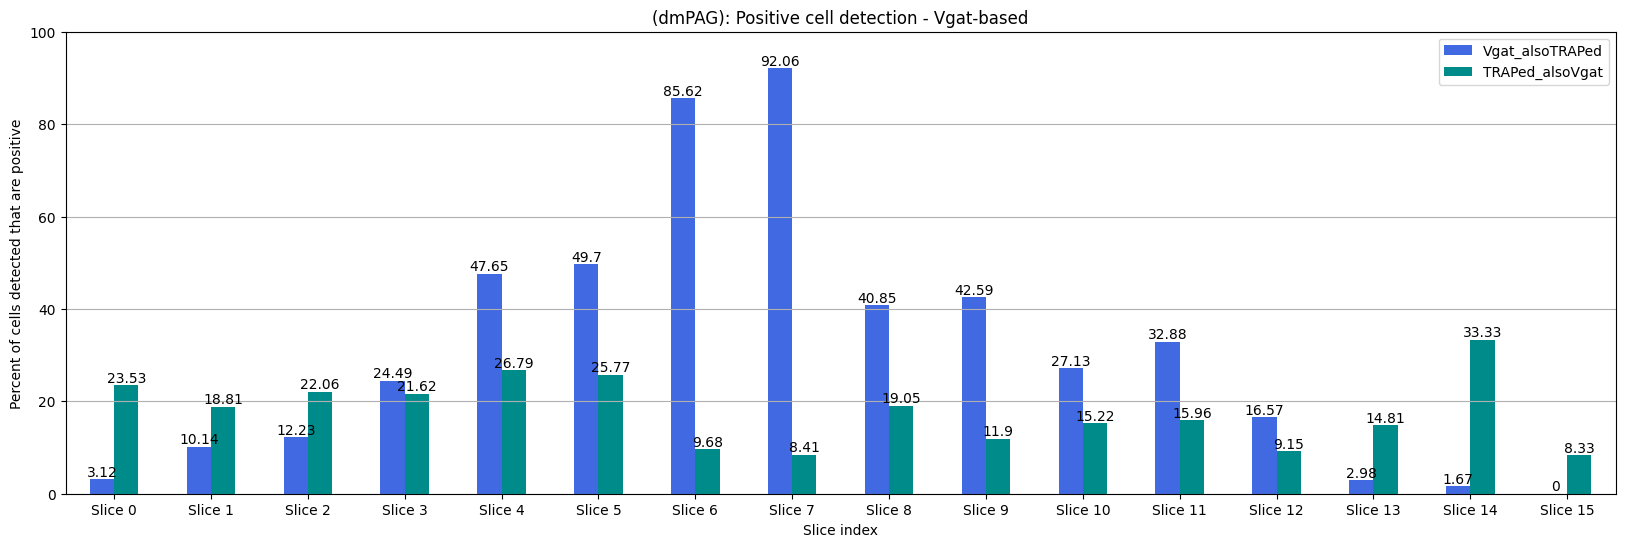

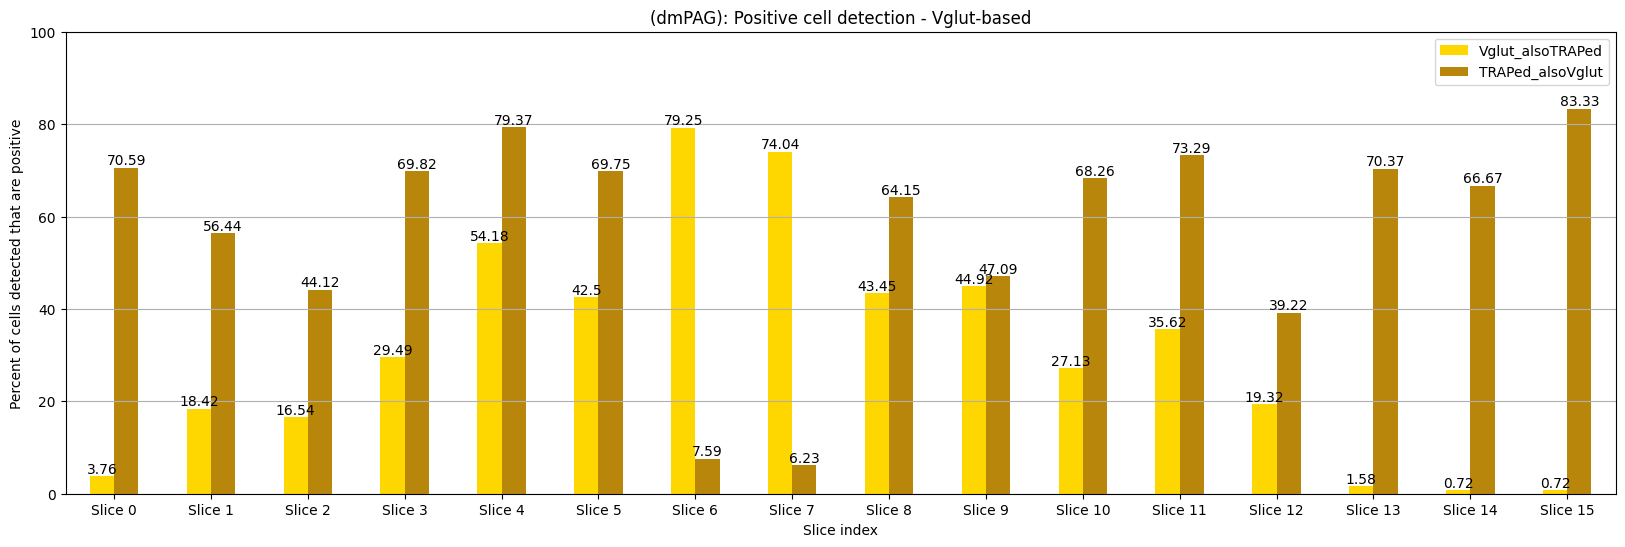

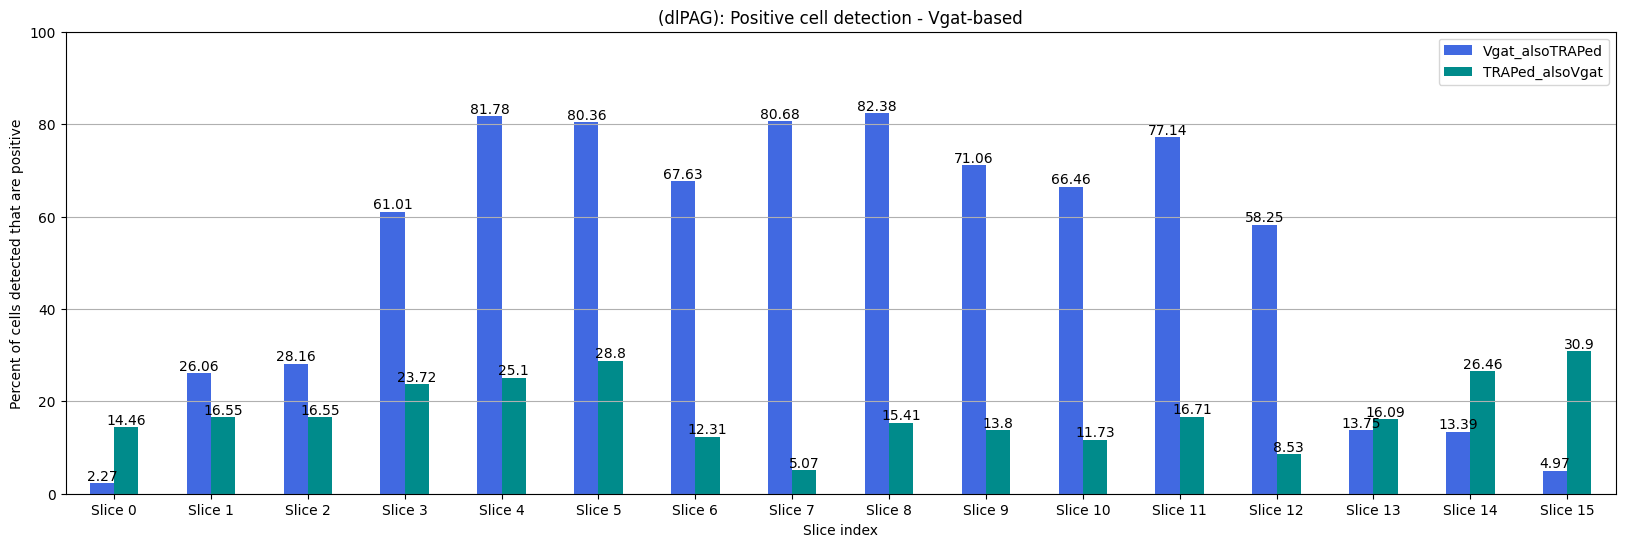

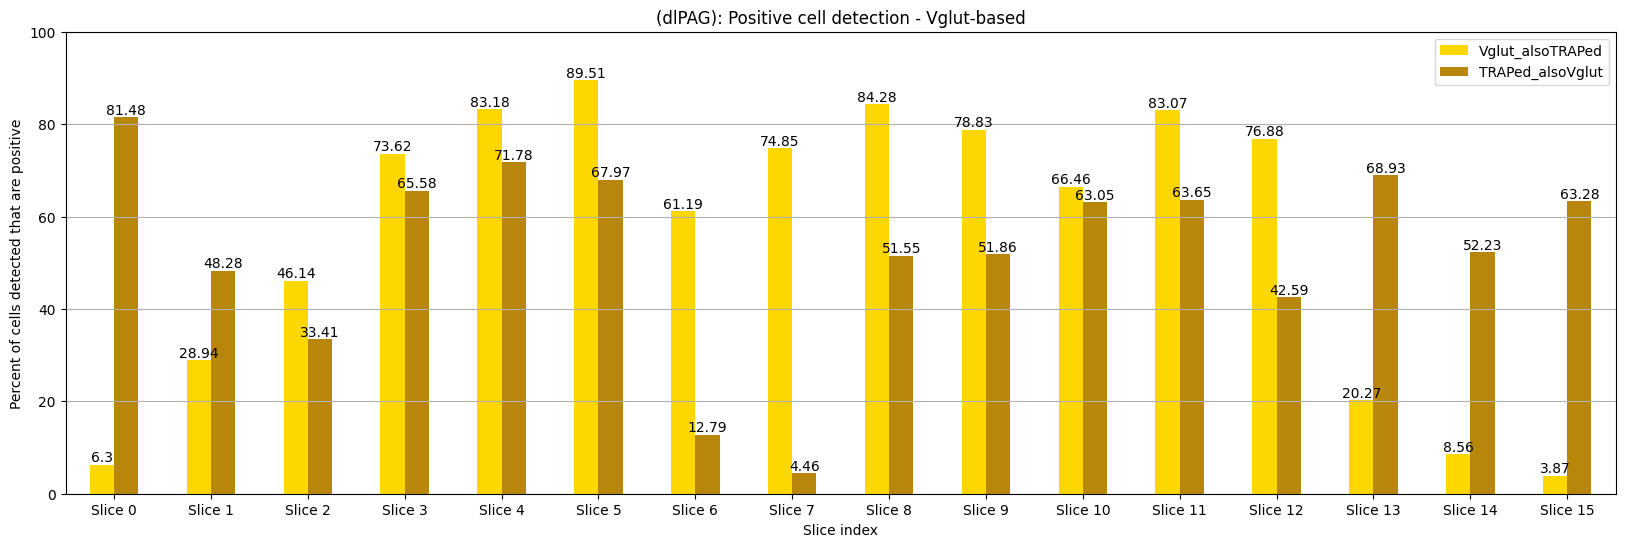

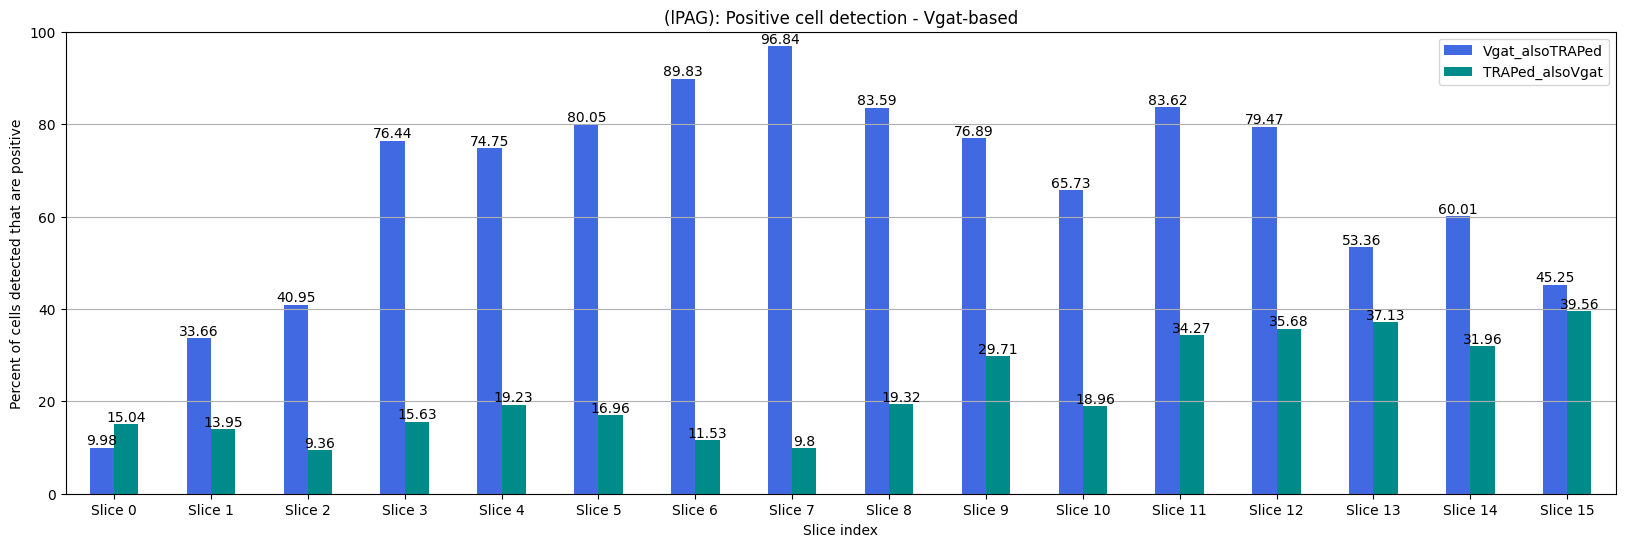

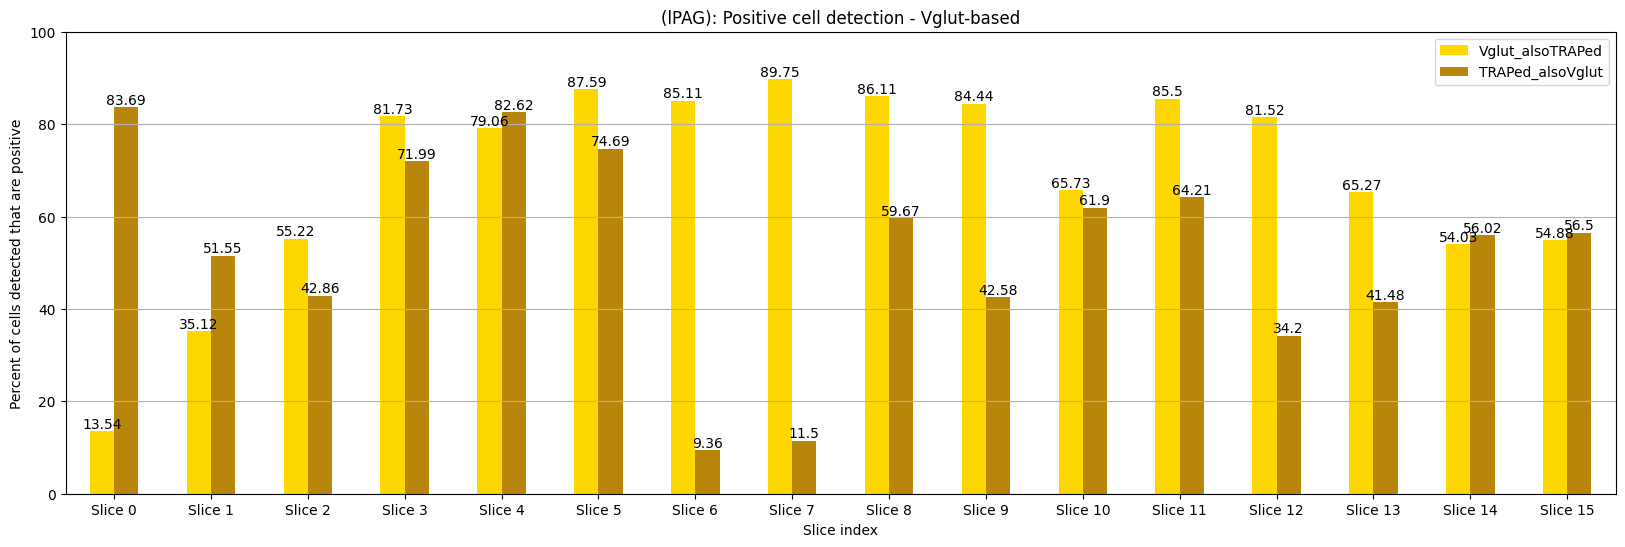

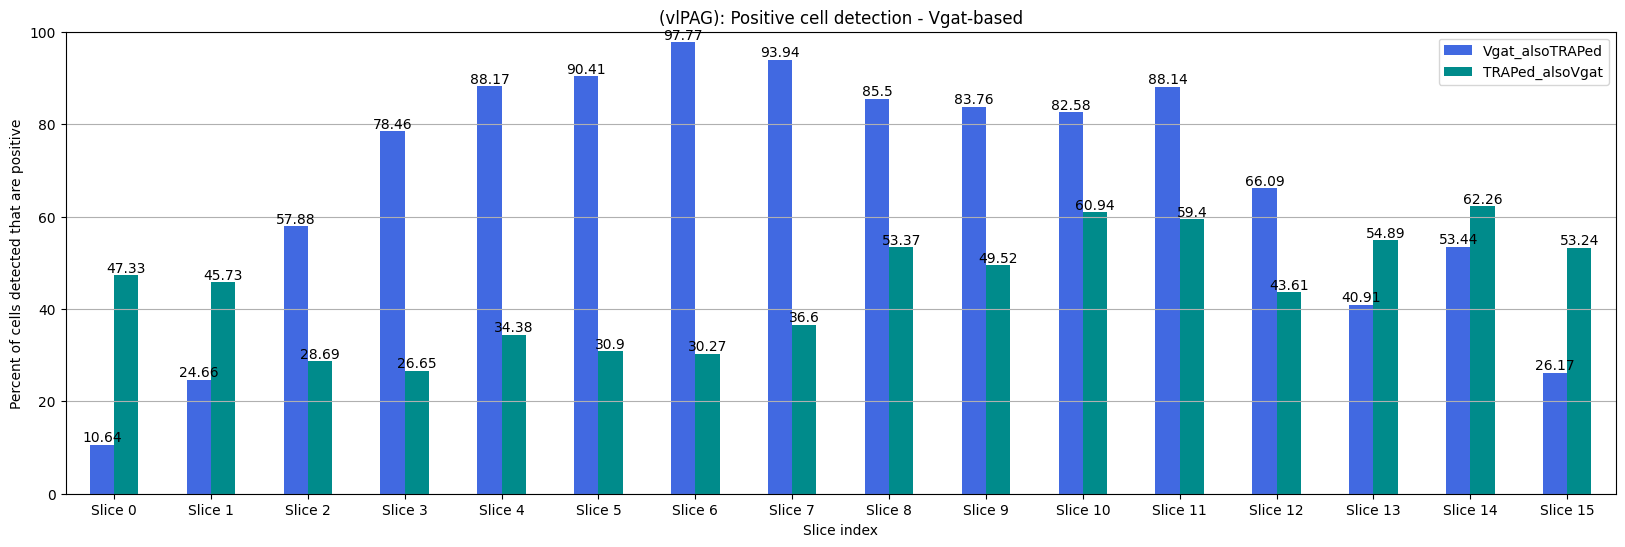

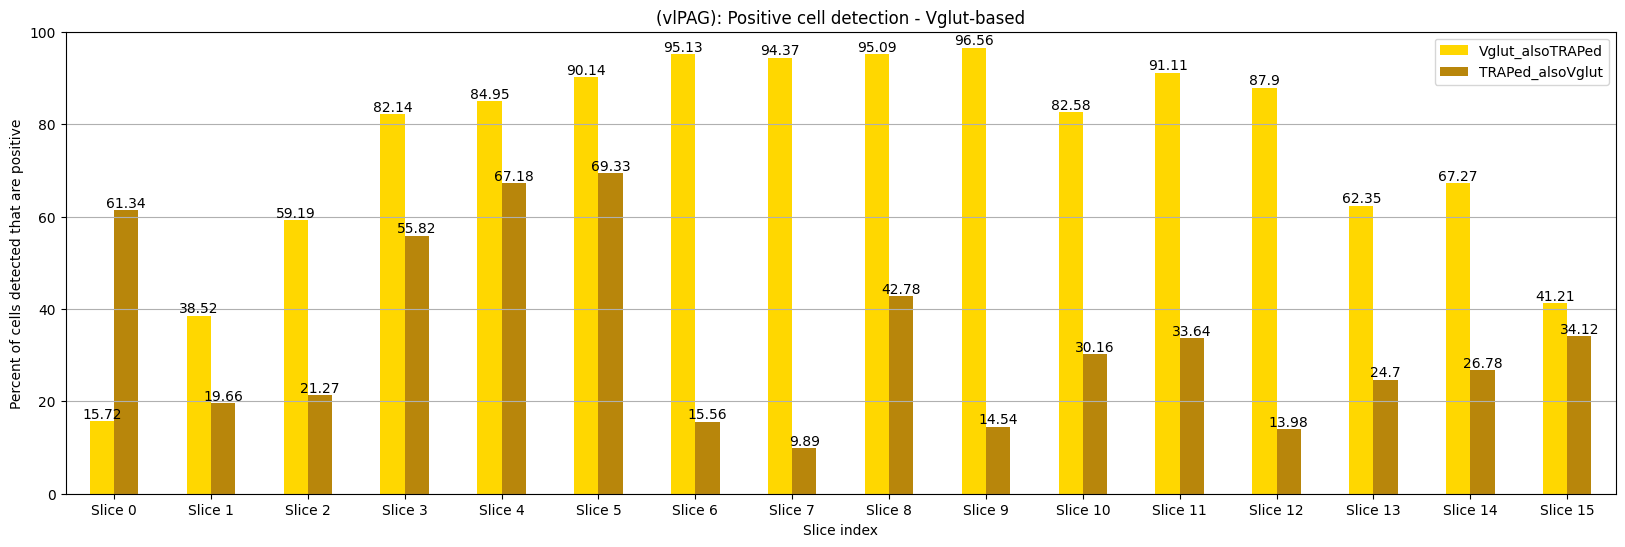

In [13]:
# https://stackoverflow.com/questions/29498652/plot-a-bar-plot-from-a-pandas-dataframe
for region in regions:
    for cell_type_pairing in column_groups: 
        print(cell_type_pairing['columns'], region)
        ax1 = results_per_slice_df_revised[results_per_slice_df_revised['Region'] == region].plot(
            x='Slice index', 
            y=[f'{cell_type_dir}' for cell_type_dir in cell_type_pairing['columns']], # FIX THIS LINE
            color=[column_colors[cell_type_directories.index(val)] for val in cell_type_pairing['columns']],
            kind='bar', 
            title=f"({region}): {cell_type_pairing['title']}", 
            figsize=(20,6), 
            ylabel='Percent of cells detected that are positive', 
            rot=0,
            ylim=[0,100]
        )
        ax1.grid(axis='y')
        for heights in ax1.containers:
            ax1.bar_label(heights)  

### Averaged brain slices

['Vgat_alsoTRAPed', 'TRAPed_alsoVgat']
['Vglut_alsoTRAPed', 'TRAPed_alsoVglut']


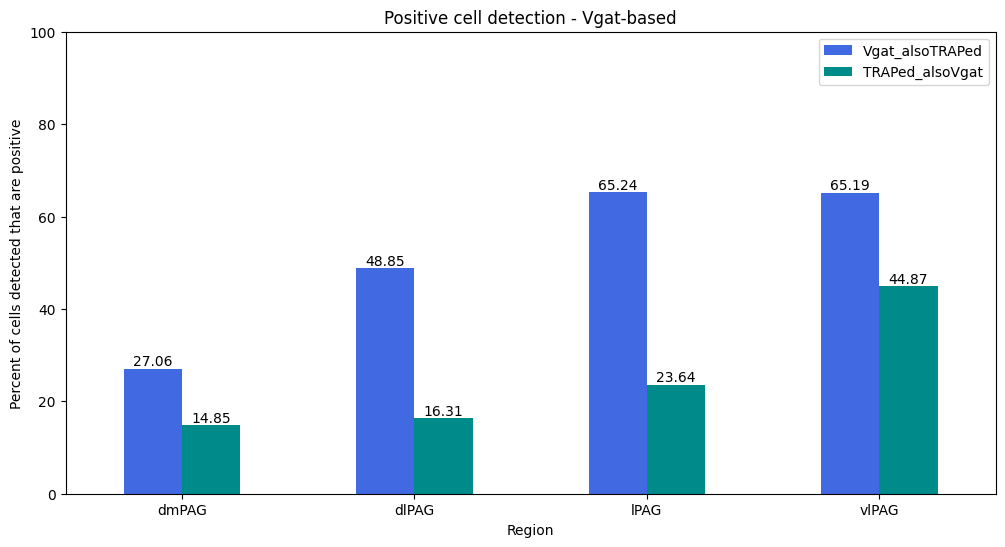

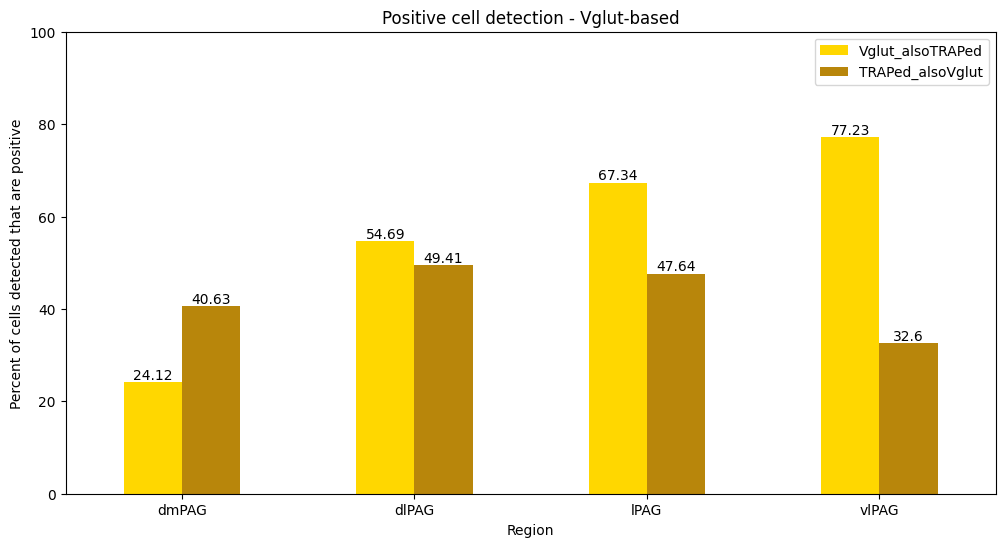

In [14]:
# https://stackoverflow.com/questions/29498652/plot-a-bar-plot-from-a-pandas-dataframe

for cell_type_pairing in column_groups: 
    print(cell_type_pairing['columns'])
    ax1 = results_per_slice_df_avg.plot(
        x='Region', 
        y=[f'{cell_type_dir}' for cell_type_dir in cell_type_pairing['columns']], 
#         yerr=errors,
#         capsize=3,
        color=[column_colors[cell_type_directories.index(val)] for val in cell_type_pairing['columns']],
        kind='bar', 
        title=cell_type_pairing['title'], 
        figsize=(12,6), 
        ylabel='Percent of cells detected that are positive', 
        rot=0,
        ylim=[0,100]
    )
    for heights in ax1.containers:
        ax1.bar_label(heights)  

In [130]:
#################################################
# save data 
#################################################

display(results_per_slice_df_avg)
vgat_vglut_alsoTRAP = {
    'Region': ['dmPAG', 'dlPAG', 'lPAG', 'vlPAG']
}
desired_cell_type = ['Vgat_alsoTRAPed', 'Vglut_alsoTRAPed'] 

for cell_type_dir in desired_cell_type:
    dmPAG = results_per_slice_df_avg[results_per_slice_df_avg['Region'] == 'dmPAG'][cell_type_dir].item()
    dlPAG = results_per_slice_df_avg[results_per_slice_df_avg['Region'] == 'dlPAG'][cell_type_dir].item()
    lPAG = results_per_slice_df_avg[results_per_slice_df_avg['Region'] == 'lPAG'][cell_type_dir].item()
    vlPAG = results_per_slice_df_avg[results_per_slice_df_avg['Region'] == 'vlPAG'][cell_type_dir].item()
    vgat_vglut_alsoTRAP[f'{cell_type_dir}_percent'] = [dmPAG, dlPAG, lPAG, vlPAG]
vgat_vglut_alsoTRAP = pd.DataFrame.from_dict(vgat_vglut_alsoTRAP)
display(vgat_vglut_alsoTRAP)

filepath = Path(f'{output_dir}/vgat_vglut_alsoTRAP.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
vgat_vglut_alsoTRAP.to_csv(filepath, index=False) 

,Region,Vgat_alsoTRAPed,Vglut_alsoTRAPed,TRAPed_alsoVgat,TRAPed_alsoVglut
0,dmPAG,3.86,5.69,9.73,79.53
1,dlPAG,39.02,47.39,14.30,80.96
2,lPAG,63.64,68.42,29.22,69.60
3,vlPAG,36.41,44.74,44.73,46.95


,Region,Vgat_alsoTRAPed_percent,Vglut_alsoTRAPed_percent
0,dmPAG,3.86,5.69
1,dlPAG,39.02,47.39
2,lPAG,63.64,68.42
3,vlPAG,36.41,44.74


## Enrichment ratios

### Individual brain slices (anterior to posterior)

In [15]:
enrichment_ratio_pairs = ['TRAPed_alsoVgat', 'TRAPed_alsoVglut']
Vgat_pairs = ['TRAPed_alsoVgat']
Vglut_pairs = ['TRAPed_alsoVglut']

enrichment_ratios = vgat_vglut_per_slice_revised.copy()
print(enrichment_ratios.shape, vgat_vglut_per_slice_revised.shape, results_per_slice_df_revised.shape)
for cell_type_pairing in Vgat_pairs:
#     display(results_per_slice_df_revised[results_per_slice_df_revised['Slice index'].isin(['Slice 16', 'Slice 17'])])
    enrichment_ratios[f'Positive % for {cell_type_pairing}'] = results_per_slice_df_revised[cell_type_pairing]
#     display(enrichment_ratios[enrichment_ratios['Slice index'].isin(['Slice 16', 'Slice 17'])])
    enrichment_ratios[f'{cell_type_pairing}'] = results_per_slice_df_revised[cell_type_pairing].div(vgat_vglut_per_slice_revised['Vgat/(Vgat+Vglut)'], axis=0)

for cell_type_pairing in Vglut_pairs:
    enrichment_ratios[f'Positive % for {cell_type_pairing}'] = results_per_slice_df_revised[cell_type_pairing]
    enrichment_ratios[f'{cell_type_pairing}'] = results_per_slice_df_revised[cell_type_pairing].div(vgat_vglut_per_slice_revised['Vglut/(Vgat+Vglut)'], axis=0)

enrichment_ratios = pd.DataFrame.from_dict(enrichment_ratios)
enrichment_ratios = enrichment_ratios.round(2)
display(enrichment_ratios)

(64, 4) (64, 4) (64, 6)


,Slice index,Region,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut),Positive % for TRAPed_alsoVgat,TRAPed_alsoVgat,Positive % for TRAPed_alsoVglut,TRAPed_alsoVglut
0,Slice 0,dmPAG,30.08,69.92,23.53,0.78,70.59,1.01
1,Slice 0,dlPAG,26.35,73.65,14.46,0.55,81.48,1.11
2,Slice 0,lPAG,17.29,82.71,15.04,0.87,83.69,1.01
3,Slice 0,vlPAG,52.15,47.85,47.33,0.91,61.34,1.28
4,Slice 1,dmPAG,43.76,56.24,18.81,0.43,56.44,1.00
...,...,...,...,...,...,...,...,...
59,Slice 14,vlPAG,71.36,28.64,62.26,0.87,26.78,0.94
60,Slice 15,dmPAG,27.74,72.26,8.33,0.30,83.33,1.15
61,Slice 15,dlPAG,36.05,63.95,30.90,0.86,63.28,0.99
62,Slice 15,lPAG,45.20,54.80,39.56,0.88,56.50,1.03


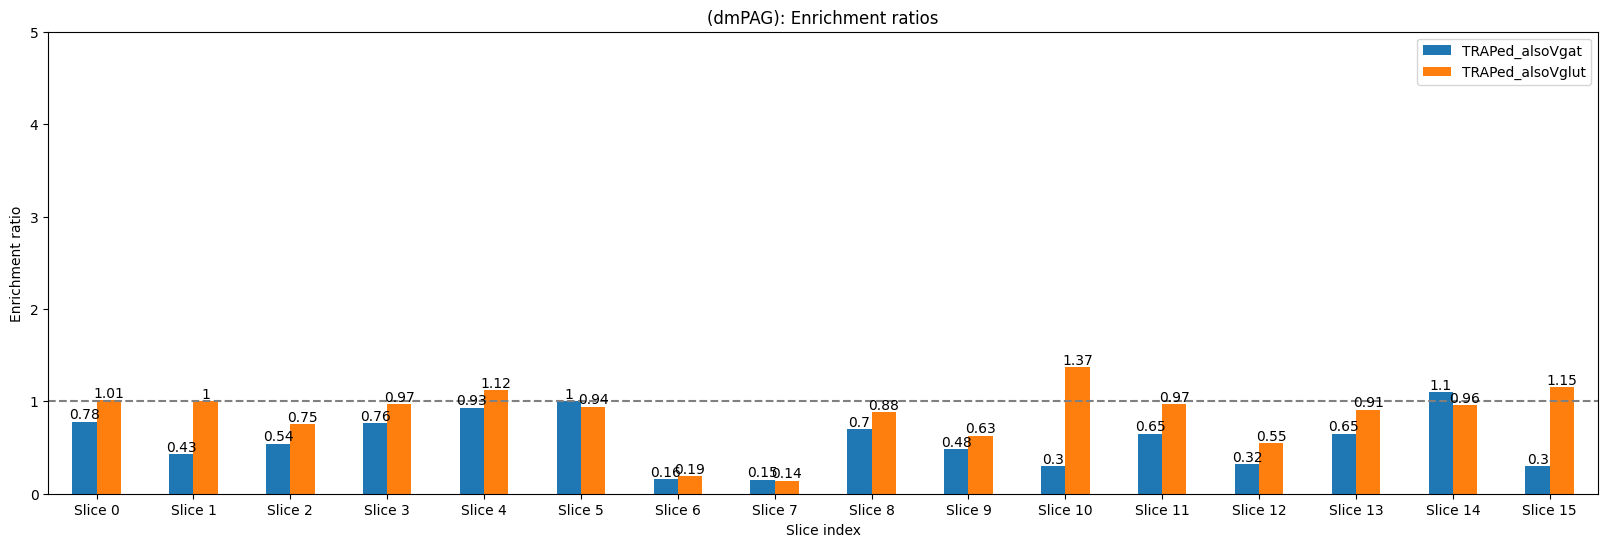

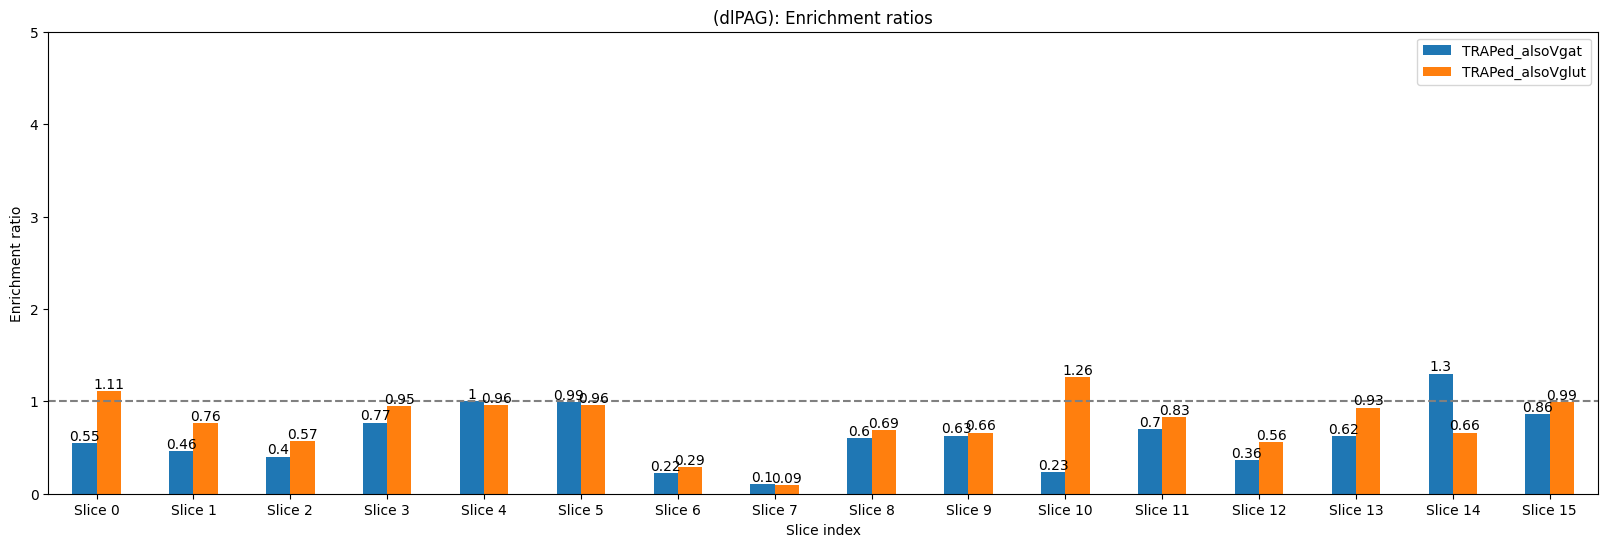

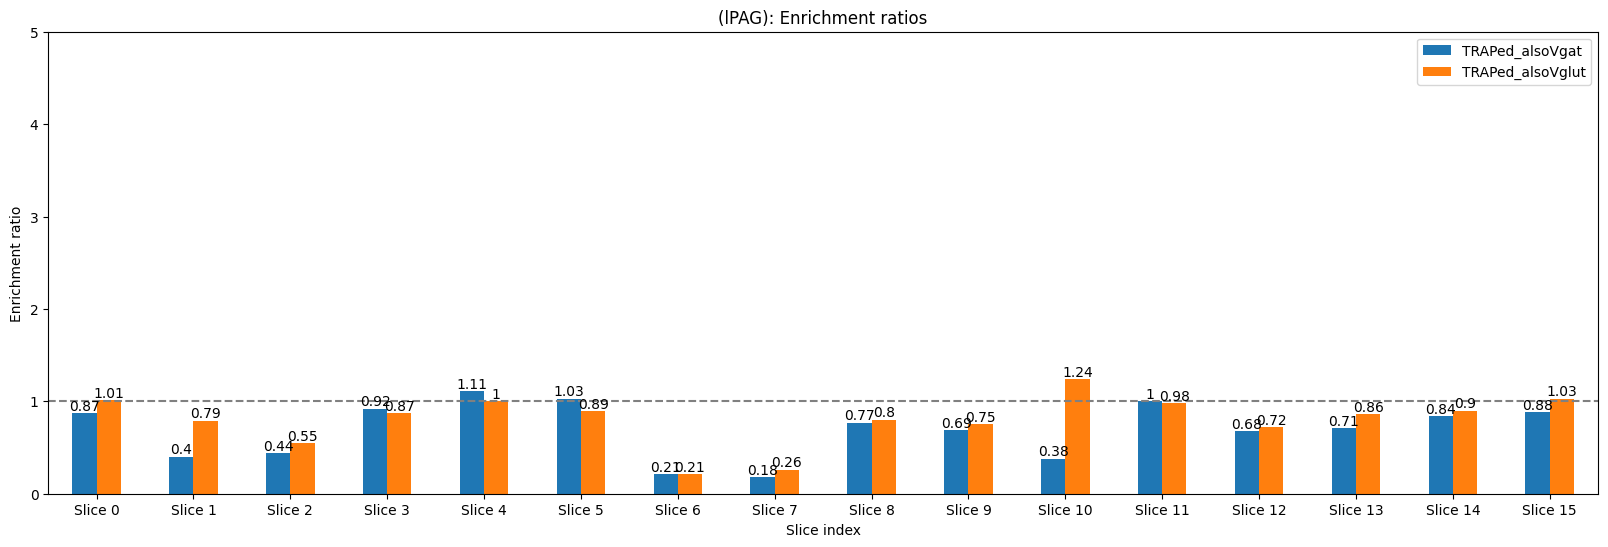

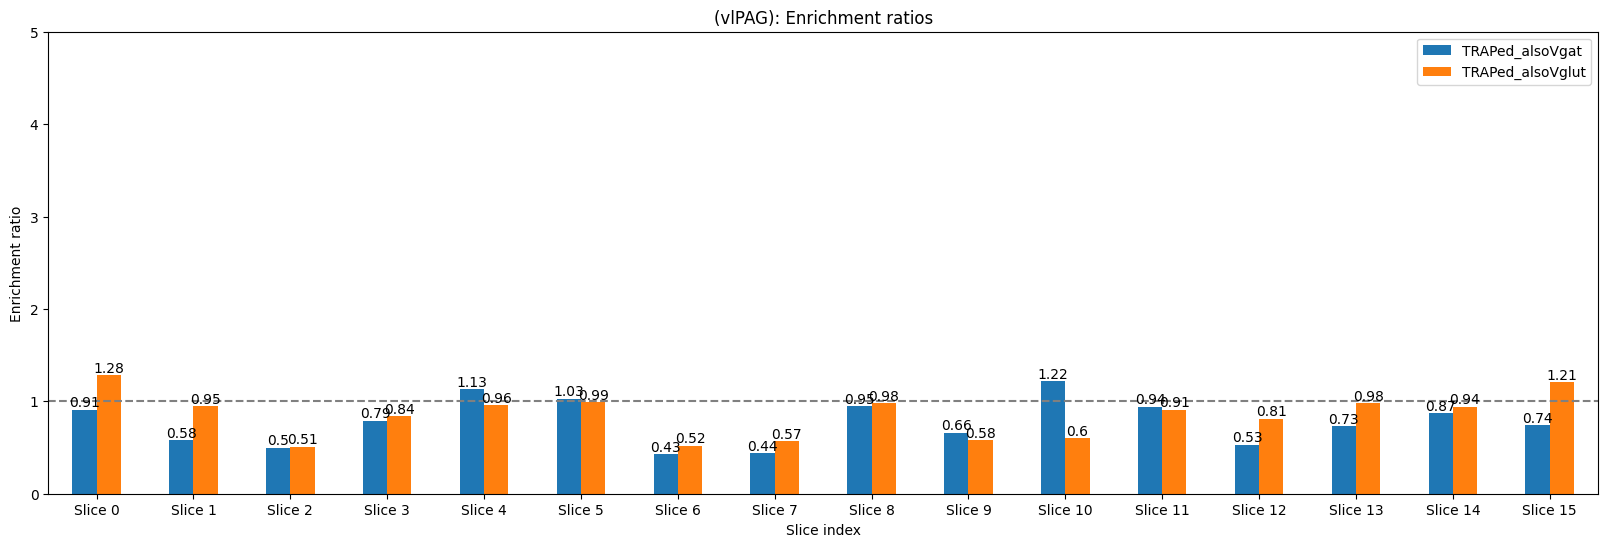

In [16]:
for region in regions:
    ax1 = enrichment_ratios[enrichment_ratios['Region'] == region].plot(
        x='Slice index', 
        y=[f'{cell_type_dir}' for cell_type_dir in enrichment_ratio_pairs],
#             color=[column_colors[cell_type_directories.index(val)] for val in cell_type_pairing['columns']],
        kind='bar', 
        title=f"({region}): Enrichment ratios", 
        figsize=(20,6), 
        ylabel='Enrichment ratio', 
        rot=0,
        ylim=[0,5]
    )
    ax1.axhline(1, ls="--", color="gray")
    for heights in ax1.containers:
        ax1.bar_label(heights)  

In [17]:
#################################################
# save slice-by-slice enrichment ratios using GLOBAL slice indices (to combine with other brains using aligned slice indices)
#################################################

global_slices = []
for slice_string in enrichment_ratios['Slice index']:
    int_idx = int(slice_string.split(" ")[-1])
#     print(int_idx)
    global_slices.append(f'Slice {global_indices[int_idx]}')
print(global_slices)
    
display(enrichment_ratios)
global_slices_enrichment_ratios = {
    'Region': enrichment_ratios['Region'],
#     'Slice index': enrichment_ratios['Slice index'],
    'Global slice index': global_slices,
    'TRAPed_alsoVgat': enrichment_ratios['TRAPed_alsoVgat'],
    'TRAPed_alsoVglut': enrichment_ratios['TRAPed_alsoVglut'],
}
global_slices_enrichment_ratios = pd.DataFrame.from_dict(global_slices_enrichment_ratios)
display(global_slices_enrichment_ratios)

# in case of multiple slices per global slice --> average the values
pooled_global_slices_enrichment_ratio = global_slices_enrichment_ratios.groupby(['Region', 'Global slice index'])[['TRAPed_alsoVgat', 'TRAPed_alsoVglut']].mean()
pooled_global_slices_enrichment_ratio = pooled_global_slices_enrichment_ratio.reset_index()
display(pooled_global_slices_enrichment_ratio)

filepath = Path(f'{output_dir}/global_slices_enrichment_ratios.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
pooled_global_slices_enrichment_ratio.to_csv(filepath, index=False) 



['Slice 0', 'Slice 0', 'Slice 0', 'Slice 0', 'Slice 0', 'Slice 0', 'Slice 0', 'Slice 0', 'Slice 1', 'Slice 1', 'Slice 1', 'Slice 1', 'Slice 1', 'Slice 1', 'Slice 1', 'Slice 1', 'Slice 2', 'Slice 2', 'Slice 2', 'Slice 2', 'Slice 2', 'Slice 2', 'Slice 2', 'Slice 2', 'Slice 3', 'Slice 3', 'Slice 3', 'Slice 3', 'Slice 3', 'Slice 3', 'Slice 3', 'Slice 3', 'Slice 4', 'Slice 4', 'Slice 4', 'Slice 4', 'Slice 4', 'Slice 4', 'Slice 4', 'Slice 4', 'Slice 5', 'Slice 5', 'Slice 5', 'Slice 5', 'Slice 6', 'Slice 6', 'Slice 6', 'Slice 6', 'Slice 6', 'Slice 6', 'Slice 6', 'Slice 6', 'Slice 7', 'Slice 7', 'Slice 7', 'Slice 7', 'Slice 7', 'Slice 7', 'Slice 7', 'Slice 7', 'Slice 8', 'Slice 8', 'Slice 8', 'Slice 8']


,Slice index,Region,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut),Positive % for TRAPed_alsoVgat,TRAPed_alsoVgat,Positive % for TRAPed_alsoVglut,TRAPed_alsoVglut
0,Slice 0,dmPAG,30.08,69.92,23.53,0.78,70.59,1.01
1,Slice 0,dlPAG,26.35,73.65,14.46,0.55,81.48,1.11
2,Slice 0,lPAG,17.29,82.71,15.04,0.87,83.69,1.01
3,Slice 0,vlPAG,52.15,47.85,47.33,0.91,61.34,1.28
4,Slice 1,dmPAG,43.76,56.24,18.81,0.43,56.44,1.00
...,...,...,...,...,...,...,...,...
59,Slice 14,vlPAG,71.36,28.64,62.26,0.87,26.78,0.94
60,Slice 15,dmPAG,27.74,72.26,8.33,0.30,83.33,1.15
61,Slice 15,dlPAG,36.05,63.95,30.90,0.86,63.28,0.99
62,Slice 15,lPAG,45.20,54.80,39.56,0.88,56.50,1.03


,Region,Global slice index,TRAPed_alsoVgat,TRAPed_alsoVglut
0,dmPAG,Slice 0,0.78,1.01
1,dlPAG,Slice 0,0.55,1.11
2,lPAG,Slice 0,0.87,1.01
3,vlPAG,Slice 0,0.91,1.28
4,dmPAG,Slice 0,0.43,1.00
...,...,...,...,...
59,vlPAG,Slice 7,0.87,0.94
60,dmPAG,Slice 8,0.30,1.15
61,dlPAG,Slice 8,0.86,0.99
62,lPAG,Slice 8,0.88,1.03


,Region,Global slice index,TRAPed_alsoVgat,TRAPed_alsoVglut
0,dlPAG,Slice 0,0.505,0.935
1,dlPAG,Slice 1,0.585,0.760
2,dlPAG,Slice 2,0.995,0.960
3,dlPAG,Slice 3,0.160,0.190
4,dlPAG,Slice 4,0.615,0.675
5,dlPAG,Slice 5,0.230,1.260
6,dlPAG,Slice 6,0.530,0.695
7,dlPAG,Slice 7,0.960,0.795
8,dlPAG,Slice 8,0.860,0.990
9,dmPAG,Slice 0,0.605,1.005


### Averaged brain slices

In [18]:
# find pooled average for enrichment ratios
display(vgat_vglut_per_slice)
pooled_vgat_vglut = vgat_vglut_per_slice.groupby('Region')[['# Vgat', '# Vglut', '# Vgat+Vglut']].sum()
enrichment_ratios_avg = pooled_vgat_vglut.copy()

for cell_type_pairing in Vgat_pairs:
    pooled = results_per_slice_df.groupby('Region')[[f'{cell_type_pairing}_numerator', f'{cell_type_pairing}_denominator']].sum()
    pooled[f'{cell_type_pairing}_percent'] = pooled[f'{cell_type_pairing}_numerator'] / pooled[f'{cell_type_pairing}_denominator'] * 100
#     display(pooled)
    pooled_vgat_vglut['Vgat/(Vgat+Vglut)'] = pooled_vgat_vglut['# Vgat'] / pooled_vgat_vglut['# Vgat+Vglut'] * 100 
#     display(pooled_vgat_vglut)
    enrichment_ratios_avg['Vgat/(Vgat+Vglut)'] = pooled_vgat_vglut['Vgat/(Vgat+Vglut)']
    enrichment_ratios_avg[f'Pooled Positive % for {cell_type_pairing}'] = pooled[f'{cell_type_pairing}_percent']
    enrichment_ratios_avg[f'{cell_type_pairing}'] = pooled[f'{cell_type_pairing}_percent'].div(pooled_vgat_vglut['Vgat/(Vgat+Vglut)'], axis=0)

for cell_type_pairing in Vglut_pairs:
    pooled = results_per_slice_df.groupby('Region')[[f'{cell_type_pairing}_numerator', f'{cell_type_pairing}_denominator']].sum()
    pooled[f'{cell_type_pairing}_percent'] = pooled[f'{cell_type_pairing}_numerator'] / pooled[f'{cell_type_pairing}_denominator'] * 100
#     display(pooled)
    pooled_vgat_vglut['Vglut/(Vgat+Vglut)'] = pooled_vgat_vglut['# Vglut'] / pooled_vgat_vglut['# Vgat+Vglut'] * 100 
#     display(pooled_vgat_vglut)
    enrichment_ratios_avg['Vglut/(Vgat+Vglut)'] = pooled_vgat_vglut['Vglut/(Vgat+Vglut)']
    enrichment_ratios_avg[f'Pooled Positive % for {cell_type_pairing}'] = pooled[f'{cell_type_pairing}_percent']
    enrichment_ratios_avg[f'{cell_type_pairing}'] = pooled[f'{cell_type_pairing}_percent'].div(pooled_vgat_vglut['Vglut/(Vgat+Vglut)'], axis=0)

display(pooled_vgat_vglut)
# enrichment_ratios_avg = pd.DataFrame.from_dict(enrichment_ratios_avg)
enrichment_ratios_avg = enrichment_ratios_avg.round(2)
enrichment_ratios_avg = enrichment_ratios_avg.reset_index()
display(enrichment_ratios_avg)

# find left-right average
enrichment_ratios_final = {
    'Region': ['dmPAG', 'dlPAG', 'lPAG', 'vlPAG']
}
for cell_type_pairing in enrichment_ratio_pairs:
    dmPAG = enrichment_ratios_avg[enrichment_ratios_avg['Region'] == 'dmPAG'][cell_type_pairing].item()
    dlPAG = round((enrichment_ratios_avg[enrichment_ratios_avg['Region'] == 'dlPAG_l'][cell_type_pairing].item() + enrichment_ratios_avg[enrichment_ratios_avg['Region'] == 'dlPAG_r'][cell_type_pairing].item())/2, 2)
    lPAG = round((enrichment_ratios_avg[enrichment_ratios_avg['Region'] == 'lPAG_l'][cell_type_pairing].item() + enrichment_ratios_avg[enrichment_ratios_avg['Region'] == 'lPAG_r'][cell_type_pairing].item())/2, 2)
    vlPAG = round((enrichment_ratios_avg[enrichment_ratios_avg['Region'] == 'vlPAG_l'][cell_type_pairing].item() + enrichment_ratios_avg[enrichment_ratios_avg['Region'] == 'vlPAG_r'][cell_type_pairing].item())/2, 2)
    enrichment_ratios_final[cell_type_pairing] = [dmPAG, dlPAG, lPAG, vlPAG]
enrichment_ratios_final = pd.DataFrame.from_dict(enrichment_ratios_final)
display(enrichment_ratios_final)

,Slice index,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
0,Slice 0,dmPAG,160,372,532,30.075188,69.924812
1,Slice 0,dlPAG_l,66,182,248,26.612903,73.387097
2,Slice 0,dlPAG_r,72,204,276,26.086957,73.913043
3,Slice 0,lPAG_l,64,317,381,16.797900,83.202100
4,Slice 0,lPAG_r,69,319,388,17.783505,82.216495
...,...,...,...,...,...,...,...
107,Slice 15,dlPAG_r,122,299,421,28.978622,71.021378
108,Slice 15,lPAG_l,241,254,495,48.686869,51.313131
109,Slice 15,lPAG_r,229,320,549,41.712204,58.287796
110,Slice 15,vlPAG_l,286,129,415,68.915663,31.084337


,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Vglut/(Vgat+Vglut)
Region,,,,,
dlPAG_l,1126,2637,3763,29.922934,70.077066
dlPAG_r,1300,3159,4459,29.154519,70.845481
dmPAG,2716,5965,8681,31.286718,68.713282
lPAG_l,1985,3487,5472,36.275585,63.724415
lPAG_r,1758,3255,5013,35.068821,64.931179
vlPAG_l,3990,2702,6692,59.623431,40.376569
vlPAG_r,3859,2588,6447,59.857298,40.142702


,Region,# Vgat,# Vglut,# Vgat+Vglut,Vgat/(Vgat+Vglut),Pooled Positive % for TRAPed_alsoVgat,TRAPed_alsoVgat,Vglut/(Vgat+Vglut),Pooled Positive % for TRAPed_alsoVglut,TRAPed_alsoVglut
0,dlPAG_l,1126,2637,3763,29.92,15.00,0.50,70.08,49.65,0.71
1,dlPAG_r,1300,3159,4459,29.15,17.62,0.60,70.85,49.17,0.69
2,dmPAG,2716,5965,8681,31.29,14.85,0.47,68.71,40.63,0.59
3,lPAG_l,1985,3487,5472,36.28,24.39,0.67,63.72,47.44,0.74
4,lPAG_r,1758,3255,5013,35.07,22.90,0.65,64.93,47.83,0.74
5,vlPAG_l,3990,2702,6692,59.62,44.31,0.74,40.38,33.27,0.82
6,vlPAG_r,3859,2588,6447,59.86,45.44,0.76,40.14,31.94,0.80


,Region,TRAPed_alsoVgat,TRAPed_alsoVglut
0,dmPAG,0.47,0.59
1,dlPAG,0.55,0.70
2,lPAG,0.66,0.74
3,vlPAG,0.75,0.81


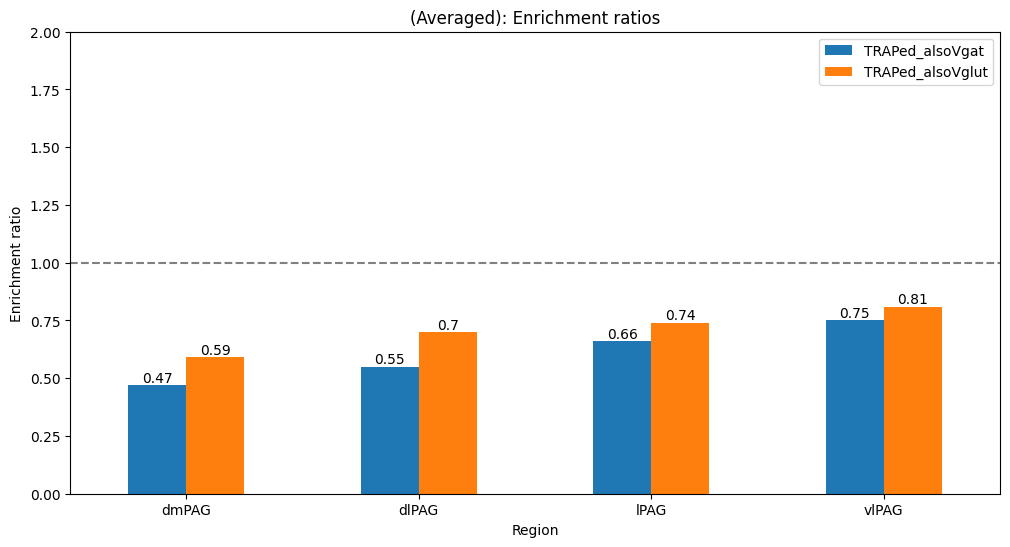

In [29]:
ax1 = enrichment_ratios_final.plot(
    x='Region', 
    y=[f'{cell_type_dir}' for cell_type_dir in enrichment_ratio_pairs], 
    kind='bar', 
    title="(Averaged): Enrichment ratios", 
    figsize=(12,6), 
    ylabel='Enrichment ratio', 
    rot=0,
    ylim=[0,2]
)
ax1.axhline(1, ls="--", color="gray")
for heights in ax1.containers:
    ax1.bar_label(heights) 